## Objective: Explore Instacart order data in order to determine where there is opportunity to increase revenue/profit.

Plan:
    1. EDA (what are the trends, peaks and lows) - Part 1
    2. Feature Engineering to optimize model - Part 2
    3. Create Model (Decision Tree/Random Forest) - Part 3
    4. Assess Models' Performance - Part 4

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None

Import all Instacart files do some EDA.

In [3]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products__prior = pd.read_csv('order_products__prior.csv')
order_products__train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

Note: Dataset is orders **over time**.

In [4]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Something to note about these tables:

difference between order_products__prior and order_products__train is that for any customer, there are between 4 and 100 orders detailed. The last order per customer is put into the train set. The orders prior to the last are put into the prior set.

In the orders table, there is an eval_set column that details which set the order belongs to: prior, train or test.

After looking at all tables' columns, can see that they all relate. The orders table can be linked to aisles, departments, products and order_products__prior based on shared columns. Therefore, for each order listed, there is information on what product was picked, in what sequence it was picked if a customer picked a series of items to be added to cart prior to checkout, how long it had been since the customer's last ordered, at what time in the week/day did the customer pick the item, what aisle and department the product came from and last but not least, whether or not the product was reordered. The last feature is the most important because that is our target value for our eventual model to predict if an item is bought again.

Before building the model, let us explore some of the peaks and tails of some of this data. This will give us a preliminary look at what are the most/least popular picked items among customers, peak times of orders, etc. Let's start!

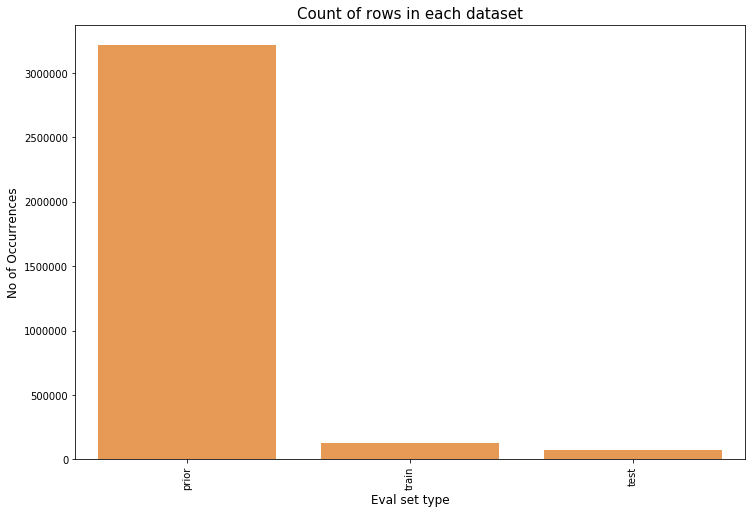

In [10]:
cnt_srs = orders.eval_set.value_counts()

plt.figure(figsize = (12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color = color[1])
plt.ylabel('No of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

This is the breakdown of how many rows from orders are in each evaluation set: prior/train/test. **Prior** has the most.

In [11]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders.groupby('eval_set')['user_id'].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

This is an output of unique customers. 206,209 in total with **131,209 as the training set** to **predict** for **75,000 customers**.

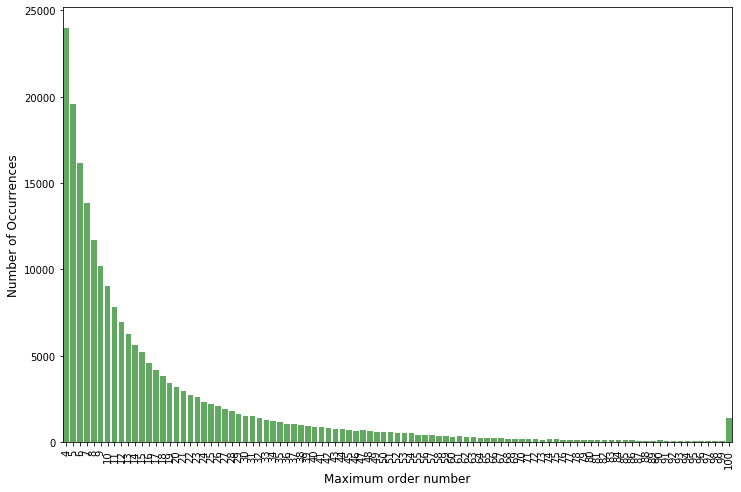

In [12]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

It is verified that for each customer, the amount of **orders are between 4 and 100**.

Let us explore customer buying habits within a week as well as within a day (hours)

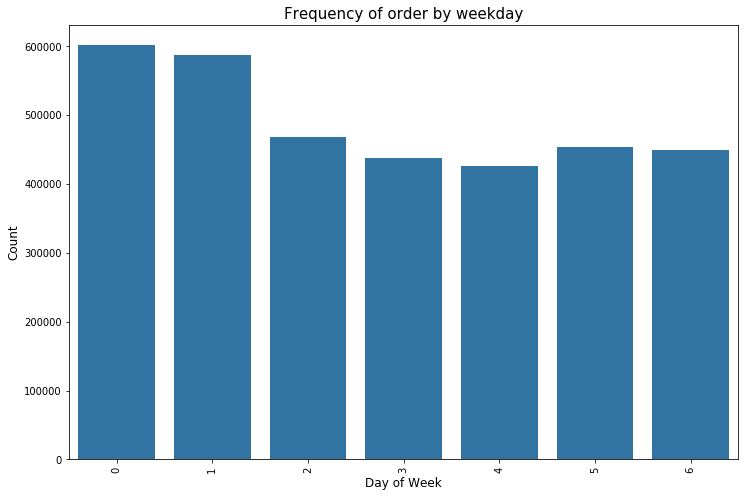

In [13]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_dow', data=orders,color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of order by weekday', fontsize=15)
plt.show()

**Saturday** and **Sunday** have the heaviest amount of orders, which make sense since this is when people usually get their errands done during the week. Whereas, Wednesday has the lowest count which is not a surprise since people usually buy groceries for the whole week.

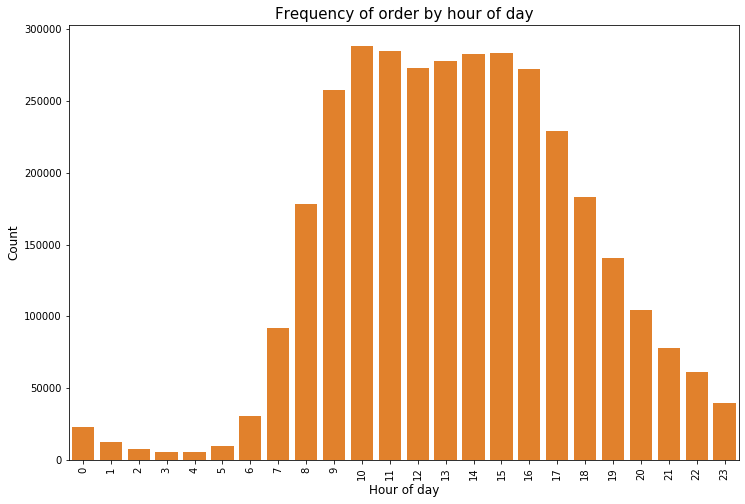

In [14]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_hour_of_day', data=orders, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of order by hour of day', fontsize=15)
plt.show()

Winner is **10AM** hour with bulk of orders made between **9AM and 4PM**.

In order to make things more interesting, will graph day in week versus hour of day to see where the concentration of orders are with this frame of time.

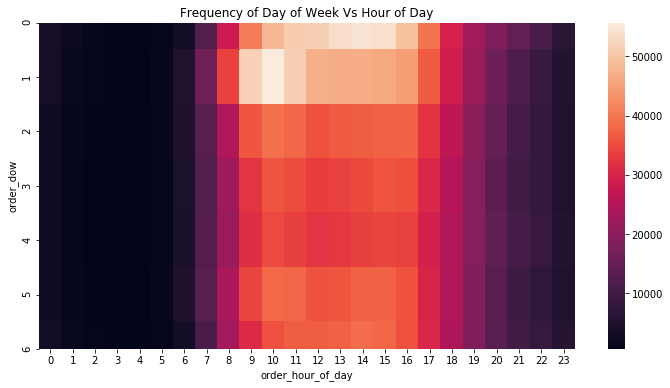

In [15]:
grouped = orders.groupby(['order_dow', 'order_hour_of_day'])['order_number'].aggregate("count").reset_index()
grouped = grouped.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped)
plt.title('Frequency of Day of Week Vs Hour of Day')
plt.show()

The heatmap shows that the most populous time for orders are: **Saturday evenings and Sunday mornings**.

Let us see what the time intervals are between orders.

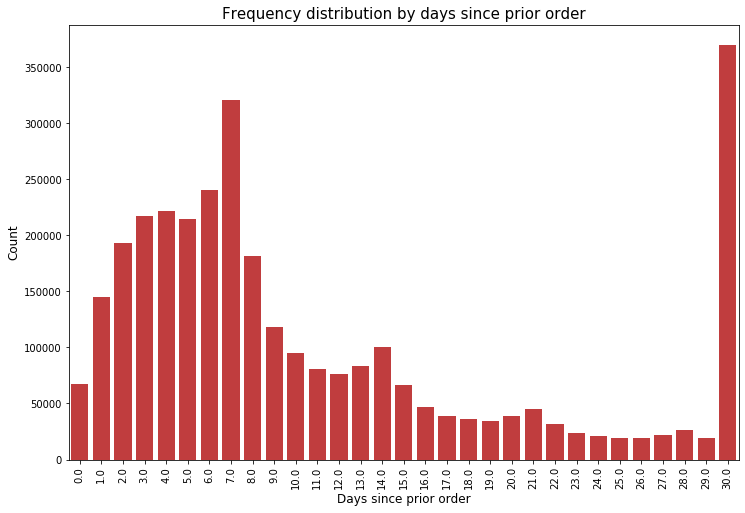

In [16]:
plt.figure(figsize=(12,8))
sns.countplot(x='days_since_prior_order', data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation = 'vertical')
plt.title('Frequency distribution by days since prior order', fontsize = 15)
plt.show()

The most frequent gap of time between orders is **30 days** (Note here is that the high amount at 30 could mean values that are >=30, which would make more sense). This means that the most frequent gap is actually **30 days or greater**. And right behind this is **7 days**. So customers usually order once a week/month. There are relative peaks at 14, 21 and 28 days, which are weekly intervals. 

Due to wanting to analyze reorders, good to know what is the percentage of reorders in prior set and train set.

In [17]:
#Prior Set Percentage
order_products__prior.reordered.sum()/order_products__prior.shape[0]

0.5896974667922161

In [18]:
#Train Set Percentage
order_products__train.reordered.sum()/order_products__train.shape[0]

0.5985944127509629

The Train set has approximately .01 more reorders though the amount between the two datasets are nearly identical. Based on the two datasets, there are **~59%** products that are reordered.

Now, let's examine the products that are not re-ordered.

In [19]:
grouped_df = order_products__prior.groupby('order_id')['reordered'].aggregate('sum').reset_index()
grouped_df['reordered'].loc[grouped_df['reordered']>1]=1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [20]:
grouped_df2 = order_products__train.groupby('order_id')['reordered'].aggregate('sum').reset_index()
grouped_df2['reordered'].loc[grouped_df2['reordered']>1]=1
grouped_df2.reordered.value_counts() / grouped_df2.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

Approximately **12% of orders from prior set** were not reordered/chosen again whereas around half of that, **6% of orders were not reordered in train set**. This means a significant amount of reorders happened. 

It would be good to see how many products were bought per order.

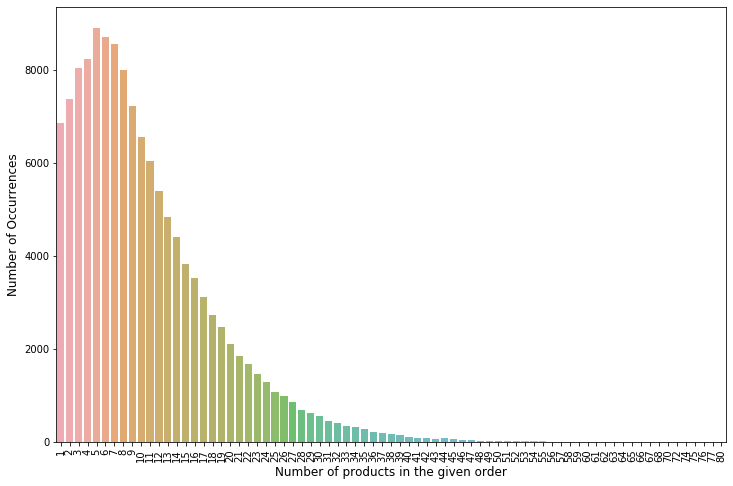

In [21]:
grouped_df3 = order_products__train.groupby('order_id')['add_to_cart_order'].aggregate('max').reset_index()
cnt_srs = grouped_df3.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Max amount of products purchased per order is **5**.

In order for a comprehensive view of an order, merging product details with order_prior details.

In [22]:
order_products__prior_df = pd.merge(order_products__prior, orders, on='order_id', how='left')
order_products__prior_df = pd.merge(order_products__prior_df, products, on='product_id', how='left')
order_products__prior_df = pd.merge(order_products__prior_df, aisles, on='aisle_id', how='left')
order_products__prior_df = pd.merge(order_products__prior_df, departments, on='department_id', how='left')
order_products__prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In order to get a closer look at our data let us check if there are any NAN's and outliers. This will allow us to prep the data if needed before building our Tree Models.

As we can see from the data analysis, there are no NAN's nor outliers. The data is clean.

Let's now get an idea of which products are bought most. What is the most popular/top-selling?

In [23]:
cnt_srs = order_products__prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


People are crazy for **organic** items and specifically **banannas, strawberries, spinich and avocados**. This could be regional as well. So it would be nice to also have gotten location information.

Let us now see which aisles are the most traversed.

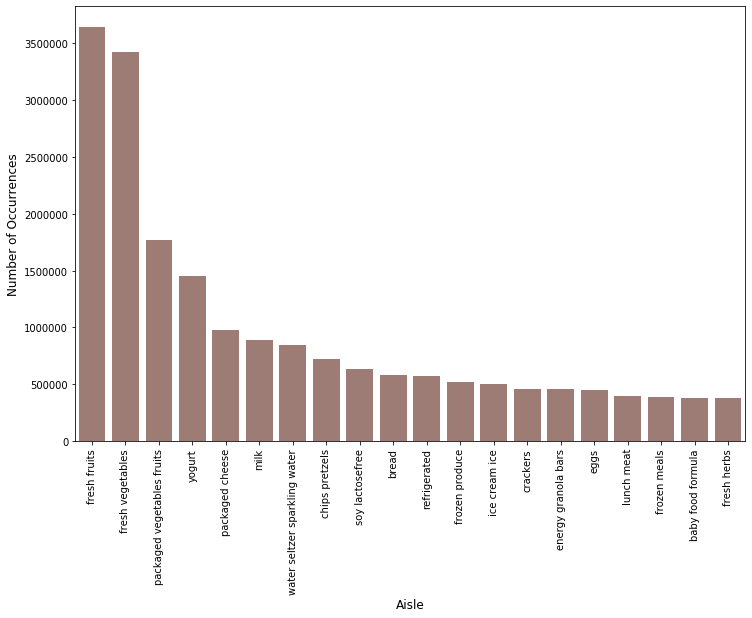

In [24]:
cnt_srs = order_products__prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Most traveled on aisles are **fresh fruits, fresh vegetables and packaged vegetables fruits**, which is in line with the top selling products' locations.

Let us now see how department popularity is broken down.

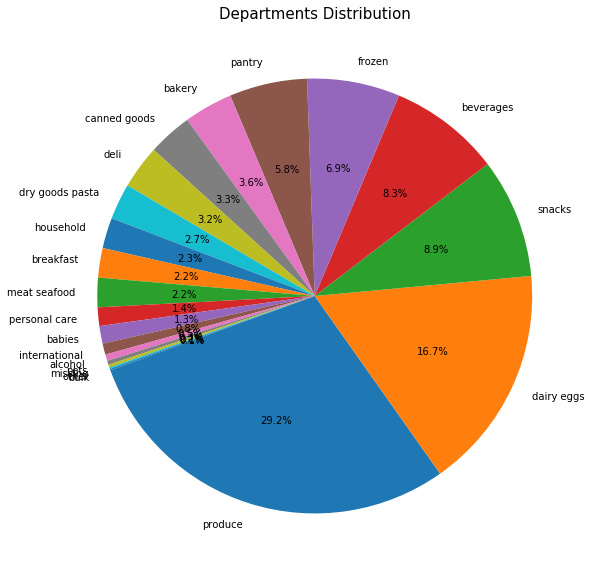

In [25]:
plt.figure(figsize=(10,10))
temp_series = order_products__prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series/temp_series.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
plt.title('Departments Distribution', fontsize = 15)
plt.show()

The **produce** and **dairy eggs** departments are the most visited for product purchases.

We can now explore the reordered ratio by department. This would reveal which are staple items in customers' fridges and pantries.

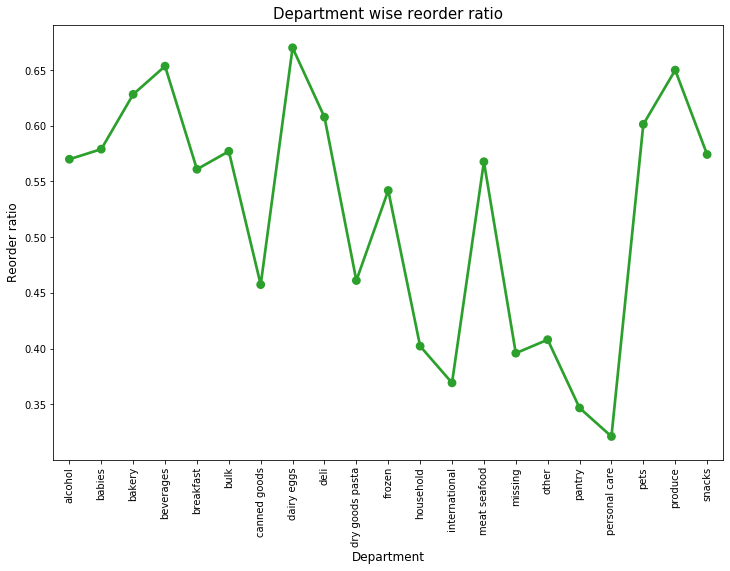

In [26]:
grouped_df4 = order_products__prior_df.groupby(['department'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df4['department'].values, grouped_df4['reordered'].values, alpha = 0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title('Department wise reorder ratio', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

The **highest** reorder ratio is **dairy eggs** and the lowest ratio is personal care. This makes sense since dairy eggs are staple grocery items.

Next up: Reordered ratio by aisle.

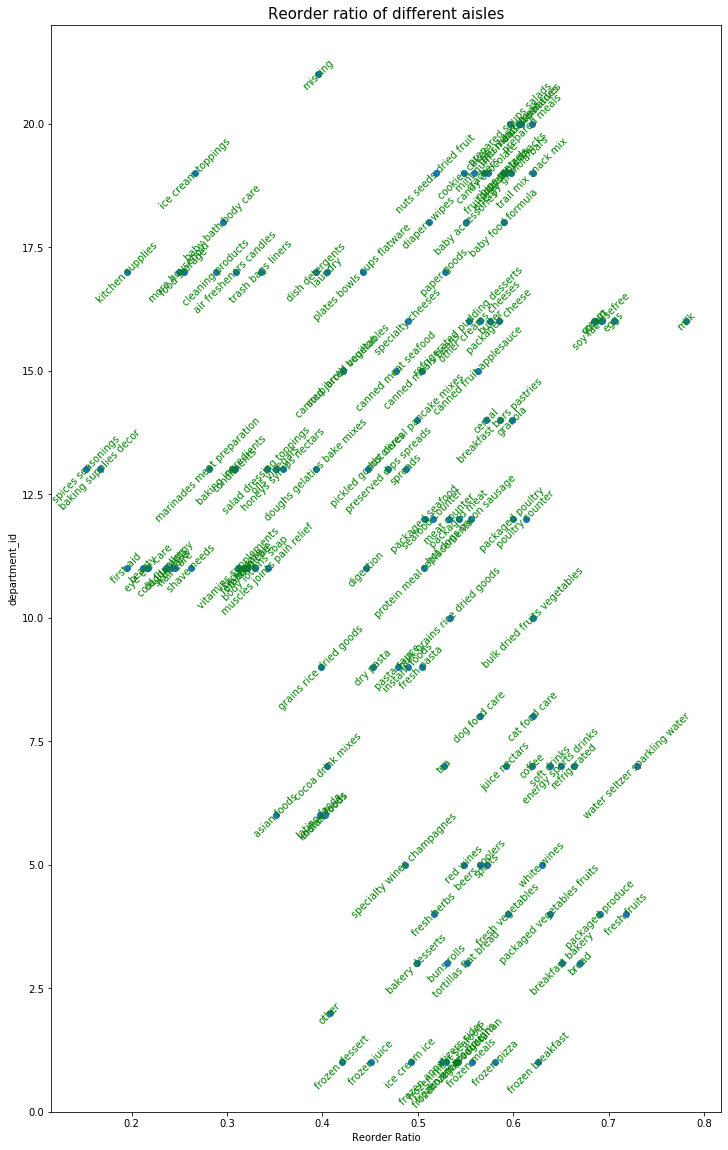

In [27]:
grouped_df5 = order_products__prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df5.reordered.values, grouped_df5.department_id.values)
for i, txt in enumerate(grouped_df5.aisle.values):
    ax.annotate(txt, (grouped_df5.reordered.values[i], grouped_df5.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

Those aisles that have a reorder ratio between 0.7 and 0.8 have the highest orders on average. They turn out to be **milk, soy lactose free, yogurt, eggs, water seltzer sparkling water, fresh fruits and packaged produce**.

Now, let us take a look at Add_to_cart Reorder Mean:

Examining how the order in which a product is added to the cart affects reorder mean.

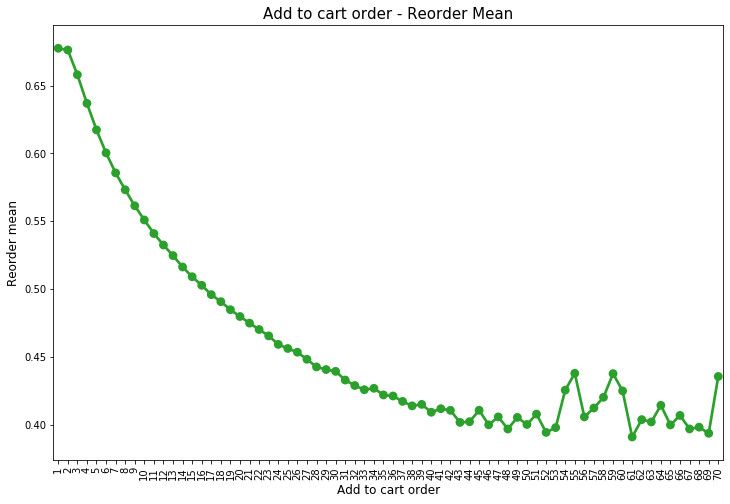

In [28]:
order_products__prior_df['add_to_cart_order_mod']= order_products__prior_df['add_to_cart_order'].copy()
order_products__prior_df['add_to_cart_order_mod'].loc[order_products__prior_df['add_to_cart_order_mod']>70]=70
grouped_df6 = order_products__prior_df.groupby(['add_to_cart_order_mod'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df6['add_to_cart_order_mod'].values, grouped_df6['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder mean', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title('Add to cart order - Reorder Mean', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.show()

Products that are **ordered first** are the most reordered. This is in line with people's usual shopping experience: what comes to mind first when shopping are items that are needed more often/consistently. Products added later to the cart are those that are usually purchased after coming across a deal-coupon/savings opportunity.

Now let us look at the Reorder mean across Time based variables. 

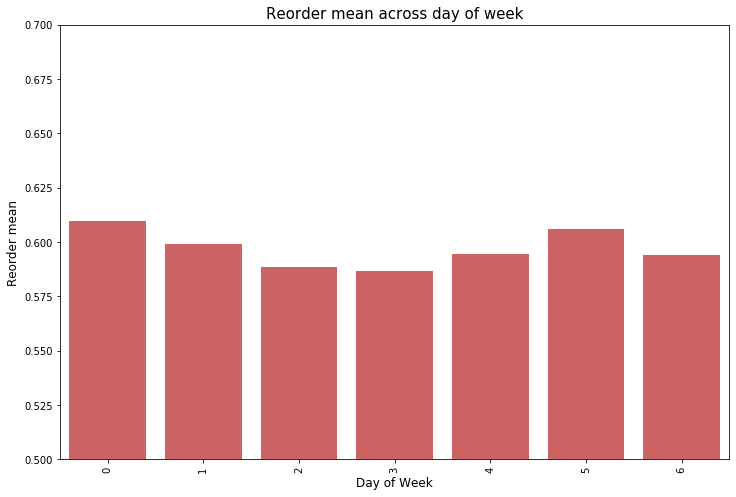

In [29]:
order_products__train_df = pd.merge(order_products__train, orders, on='order_id', how='left')
grouped_df7 = order_products__train_df.groupby(['order_dow'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df7['order_dow'].values, grouped_df7['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder mean', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.title('Reorder mean across day of week', fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5,0.7)
plt.show()

**Saturday** and **Thursday** have the greatest average number of reorders out of the whole week. 

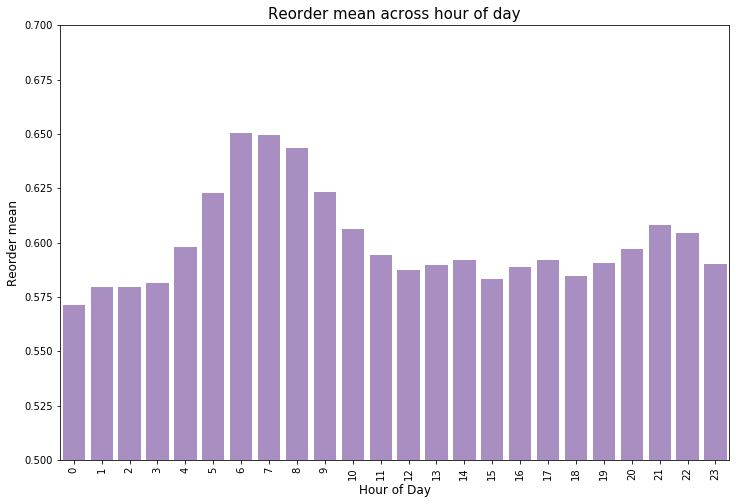

In [30]:
grouped_df8 = order_products__train_df.groupby(['order_hour_of_day'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df8['order_hour_of_day'].values, grouped_df8['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder mean', fontsize=12)
plt.xlabel('Hour of Day', fontsize=12)
plt.title('Reorder mean across hour of day', fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5,0.7)
plt.show()

Hours in the day with the most average reorders are between **6AM and 8AM**.

Lastly, let us combine the reorder ratios from day of week and hour of day to see per day, what hours of the day have the most reorders.

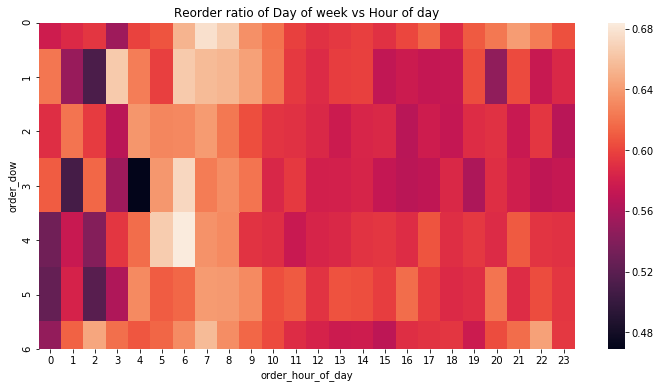

In [31]:
grouped_df9 = order_products__train_df.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate('mean').reset_index()
grouped_df9 = grouped_df9.pivot('order_dow', 'order_hour_of_day','reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df9)
plt.title('Reorder ratio of Day of week vs Hour of day')
plt.show()

**Early mornings** throughout the week have the highest reorders.

Lastly, we will see how clean and structured the data is before heading into our Feature Engineering portion.

In [32]:
order_products__prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department,add_to_cart_order_mod
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs,1
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce,2
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry,3
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry,4
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry,5


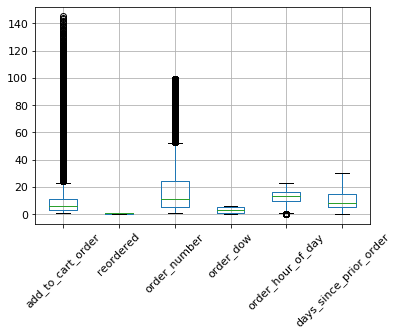

In [33]:
#Extract from main table numerical data only (no strings/object-type data)
order_products__prior_df_mod = order_products__prior_df.drop(['product_name', 'aisle', 'department', 'eval_set'], axis=1)

boxplot = order_products__prior_df_mod.boxplot(column=['add_to_cart_order', 'reordered', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'],rot=45, fontsize=11)

Great! The data is free of outliers. Now, final check is to see if there are NaN's.

In [34]:
#We are checking the original df with merged products, orders, aisles and department tables. 
order_products__prior_df.isnull().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
add_to_cart_order_mod           0
dtype: int64

In [43]:
order_products__prior_df.shape 

(32434489, 16)

For days_since_prior_order, only 2078068/32434489= 0.064 * 100% = 6.4% are NaN's.
Three options to handle this: 
1. Replace NaN's with average of of feature.
2. Replace NaN's with 0.
3. Get rid of all NaN's since they represent a small fraction of the whole dataset.

Goal of dataset is to be the best representation of customer's true behavior. 
Decision will be to get rid of all rows with NaN's since assigning a customer 0/average number has a lot of assumption behind it.

So let's get rid of the NaN's from the df that will be fed into the Tree algorithms (order_products__prior_df_mod).

In [45]:
#Amount of rows in DF with NaN's
order_products__prior_df_mod.shape

(32434489, 12)

In [46]:
order_products__prior_df_mod2 = order_products__prior_df_mod.dropna()

In [48]:
order_products__prior_df_mod2.shape

(30356421, 12)

Now we have a dataframe we can work with to feed into our Tree models. In order to enhance its power to predict, let us first create some more features to ensure the highest accuracy possible when the tree model is fed test/unseen data.